In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
import gc

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
df = pd.read_csv(r"/content/drive/MyDrive/Battery data/full_battery_data.csv")
print(f"✅ Loaded full dataset: {df.shape}")


✅ Loaded full dataset: (9047247, 7)


In [12]:
df.head()

,Time,Voltage,Current,Temperature,SOC,DriveCycle,TemperatureLabel
0,0.0,4.175155,-3.691549e-06,15.96381,1.0,PDTCB,15
1,0.1,4.175155,-9.512327e-07,15.96381,1.0,PDTCB,15
2,0.2,4.174967,-4.821614e-07,15.96381,1.0,PDTCB,15
3,0.3,4.175153,-2.413463e-07,15.96381,1.0,PDTCB,15
4,0.4,4.174966,-8.059866e-08,15.96381,1.0,PDTCB,15


In [13]:
df.tail()

,Time,Voltage,Current,Temperature,SOC,DriveCycle,TemperatureLabel
9047242,11025.7,2.656538,-3.350742,8.943850,0.125165,US06,5
9047243,11025.8,2.655582,-3.351976,8.943850,0.125146,US06,5
9047244,11025.9,2.654630,-3.353234,8.945311,0.125128,US06,5
9047245,11026.0,2.653594,-3.354528,8.947360,0.125109,US06,5
9047246,11026.1,2.450127,-9.408817,8.947360,0.125090,US06,5


In [14]:
# 2. Normalize SOC to 0–1 range if needed
if df["SOC"].max() > 1.0:
    df["SOC"] = df["SOC"] / 100.0

# 3. Select features and target
features = ['Voltage', 'Current', 'Temperature']
target = 'SOC'

X = df[features].values
y = df[target].values

In [15]:
# Free up memory
del df
gc.collect()

31

In [16]:
# 4. Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"✅ Train shape: {X_train.shape}, Test shape: {X_test.shape}")

✅ Train shape: (7237797, 3), Test shape: (1809450, 3)


In [17]:
# 5. Initialize Random Forest (memory-optimized)
rf_model = RandomForestRegressor(
    n_estimators=100,       # You can lower this if you face memory issues
    max_depth=15,           # Control tree size to limit memory
    max_samples=0.8,        # Use 80% of data per tree (bootstrapped)
    n_jobs=-1,              # Use all CPU cores
    random_state=42,
    verbose=1
)

In [18]:
# 6. Train the model
print("⏳ Training Random Forest on 9M rows...")
rf_model.fit(X_train, y_train)
print("✅ Training complete.")

⏳ Training Random Forest on 9M rows...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.1min


✅ Training complete.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.1min finished


In [19]:
import joblib
joblib.dump(rf_model, "random_forest_soc_modelv2.pkl")
print("✅ Model saved as 'random_forest_soc_model.pkl'")


✅ Model saved as 'random_forest_soc_model.pkl'


In [20]:
# Predictions and evaluation
y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    4.9s finished


In [29]:
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")

MAE:  0.007
RMSE: 0.011
R²:   0.998


/tmp/ipython-input-22-2025969715.py:10: UserWarning: Glyph 128267 (\N{BATTERY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128267 (\N{BATTERY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


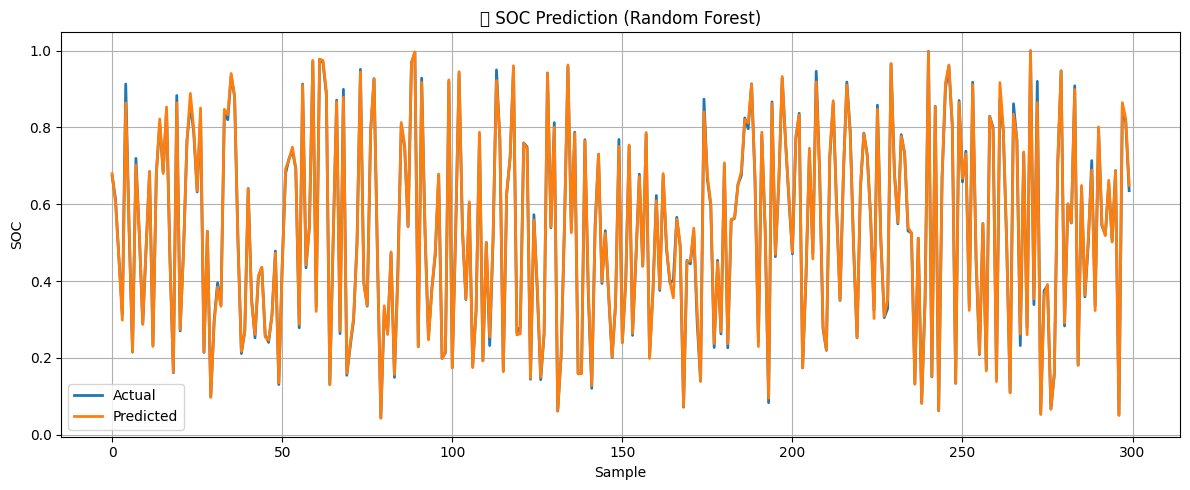

In [22]:
# 9. Visualization
plt.figure(figsize=(12, 5))
plt.plot(y_test[:300], label='Actual', linewidth=2)
plt.plot(y_pred[:300], label='Predicted', linewidth=2)
plt.title("🔋 SOC Prediction (Random Forest)")
plt.xlabel("Sample")
plt.ylabel("SOC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-30-965197480.py:15: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


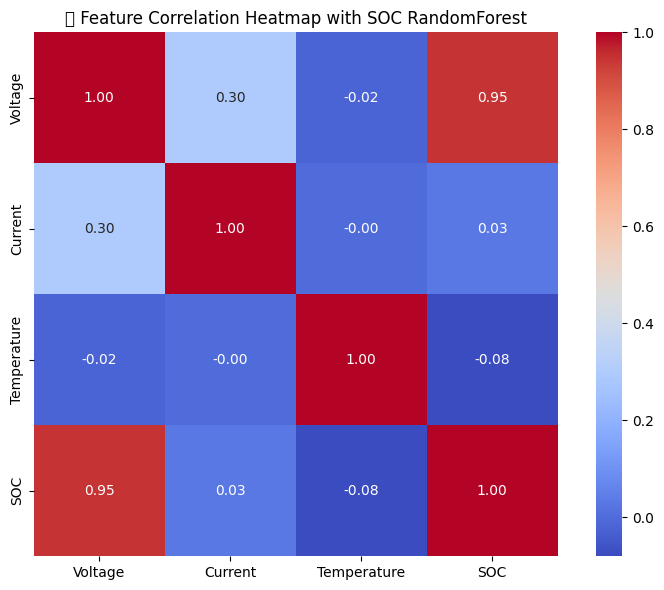

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine into DataFrame again if you used NumPy arrays
df_corr = pd.DataFrame(X_test, columns=['Voltage', 'Current', 'Temperature'])
df_corr['SOC'] = y_test

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("📊 Feature Correlation Heatmap with SOC RandomForest")
plt.tight_layout()
plt.show()


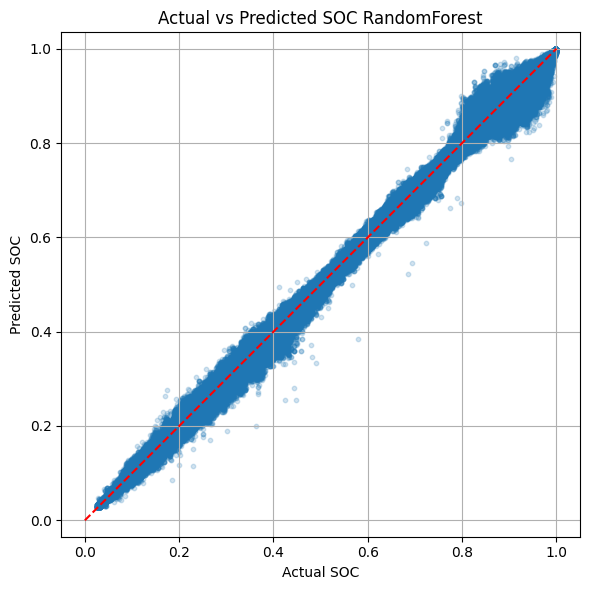

In [31]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.2, s=10)
plt.plot([0, 1], [0, 1], 'r--')  # Ideal line
plt.title("Actual vs Predicted SOC RandomForest")
plt.xlabel("Actual SOC")
plt.ylabel("Predicted SOC")
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


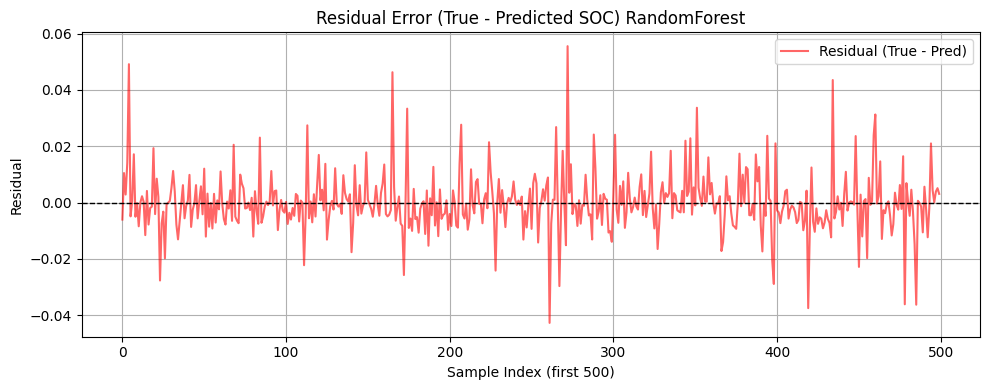

In [32]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals over sample index
plt.figure(figsize=(10, 4))
plt.plot(residuals[:500], color='red', alpha=0.6, label='Residual (True - Pred)')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Residual Error (True - Predicted SOC) RandomForest")
plt.xlabel("Sample Index (first 500)")
plt.ylabel("Residual")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

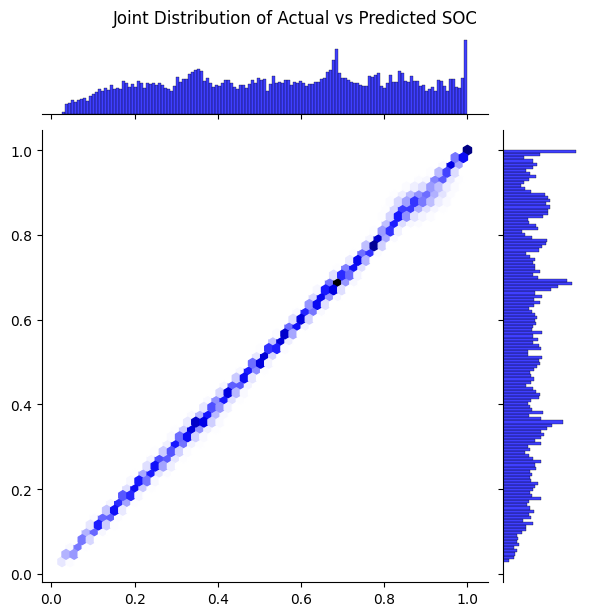

In [26]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.jointplot(
    x=y_test, y=y_pred,
    kind='hex', color='blue',
    height=6
)
plt.suptitle("Joint Distribution of Actual vs Predicted SOC RandomForest", y=1.02)
plt.show()


In [27]:
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_absolute_error')
# print(f"Avg MAE: {-scores.mean():.5f}")
